## Import libraries

In [60]:
import pandas as pd
from os import listdir
from os.path import isfile, join
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import numpy as np

## Set directories

In [61]:
abspath_curr = os.path.join(os.getcwd())
data_path = os.path.join(abspath_curr, 'data')

## Read in dataframes and concatenate them

In [64]:
def stitch_frames(data_path):
    frames = []
    for subdir, dirs, files in os.walk(data_path):
        for file in files:
            if subdir.endswith('_run') and file.endswith('_tweets.csv'):
                path = os.path.join(subdir, file)
                df = pd.read_csv(path, index_col=None, header=0)
                frames.append(df)
    df = pd.concat(frames, axis=0, ignore_index=True)
    return df

## Clean the data and save

In [87]:
def clean_data():
    
    df = stitch_frames(data_path)
    
    # Remove duplicates
    original_shape = df.shape[0]
    df = df.drop_duplicates(subset='tweet_id')
    print(f'Removed {original_shape - len(df)} duplicate tweets.')
    
    # Remove emojis
    df[['user_name', 'screen_name', 'text']] = df[['user_name', 'screen_name', 'text']].astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

    # Extract coordinates from place column and add to dataframe
    place_series = df.place[pd.isnull(df.place) == False]
    def create_coords(x):
        y = x.split('coordinates=[[')[1].split(']])')[0].replace('[', '').replace(']', '').replace(',', '').split()
        return [[float(y[i]), float(y[i+1])] for i in range(0, len(y), 2)]
    coords = place_series.apply(lambda x: create_coords(x))
    df['coordinates'] = coords

    # Add sentiment column
    df['sentiment'] = df.text.apply(lambda x: TextBlob(x).sentiment[0])

    # Add sentiment pos/neg column
    df['pos_neg'] = df.sentiment.apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

    # Create datetimes
    df.created_at = pd.to_datetime(df.created_at)

    # Write to directory
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
    file_name = os.path.join(data_path, to_csv_timestamp + 'clean_streaming_data.csv')
    df.to_csv(file_name, encoding='utf-8-sig')
    
    return df

In [88]:
df = clean_data()
df

C:\Users\raide\AppData\Local\Temp/ipykernel_3876/2810709486.py:3: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  df = stitch_frames(data_path)


Removed 114 duplicate tweets.


,created_at,tweet_id,user_id,user_name,screen_name,verified,text,quote_tweet,rewteet_count,favorite_count,place,quote_status_id,entities,hashtags,coordinates,sentiment,pos_neg
0,2021-10-16 22:39:56+00:00,1449505417495674882,1002434346,Anna Mae,AMysticMuse,False,@chxnel_shit honey you cant even type out full...,False,0,0,NaN,NaN,NaN,NaN,NaN,-0.075000,negative
1,2021-10-16 22:39:56+00:00,1449505417491619842,300289849,Simon Sheppard,SeagullSimon,False,I just wrote a little poem to Dad.\n\nAn ode t...,False,0,0,NaN,NaN,NaN,NaN,NaN,-0.187500,negative
2,2021-10-16 22:39:56+00:00,1449505417688715270,4832818479,Owura,ok_ayanful,False,RT @Chinnyb_: Please if weve had sex dont go a...,False,0,0,NaN,NaN,NaN,NaN,NaN,0.000000,neutral
3,2021-10-16 22:39:56+00:00,1449505417491587075,30597662,tori.,toricantstfu,False,Also very fire https://t.co/fdUwGN4qM7,False,0,0,NaN,NaN,NaN,NaN,NaN,0.200000,positive
4,2021-10-16 22:39:56+00:00,1449505418191966209,1164673677214081025,59(Mltei ),Khloud51031660,False,RT @a_neimi: @MigrationPolicy @ekztarf Please ...,False,0,0,NaN,NaN,NaN,NaN,NaN,0.100000,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010186,2021-10-19 12:15:08+00:00,1450435343765807107,1271356711236890625,Bella || MC Sunghoon,b_yjunie,False,RT @chartdata: Billboard Hot 100: #18(-6) My U...,False,0,0,NaN,NaN,NaN,NaN,NaN,0.250000,positive
1010187,2021-10-19 12:15:08+00:00,1450435343820496901,1110674880805122048,PLAN3T.Makiyiaaa,QueenKiy3,False,At work sipping my coffee,False,0,0,NaN,NaN,NaN,NaN,NaN,0.000000,neutral
1010188,2021-10-19 12:15:08+00:00,1450435344470585344,906687259,VaniA,vania3011,False,RT @mi_woo17: Cheol Gyu on their way back from...,False,0,0,NaN,NaN,NaN,NaN,NaN,-0.216667,negative
1010189,2021-10-19 12:15:08+00:00,1450435344097292290,20530864,Carl Hamilton | Hamilton Technology,chtsiuk,False,Hot desking seems like a good idea for the mos...,False,0,0,NaN,NaN,NaN,NaN,NaN,0.362500,positive


## Create wordcloud

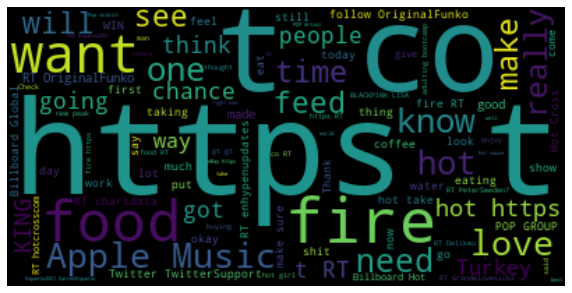

In [83]:
# Get string of all text
text = " ".join(text for text in df.text)

# Generate wordcloud image
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, max_font_size=100, max_words=100, background_color="black", mode="RGBA").generate(text)

# Display wordcloud image
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
image_path = os.path.join(abspath_curr, 'images')
image_file_path = os.path.join(image_path, 'clean_streaming_data_wordcloud.png')
plt.savefig(image_file_path, format="png")
plt.show()

## Plot sentiment

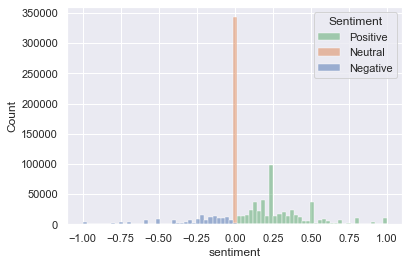

In [84]:
sns.set_theme(style="darkgrid")
sns.histplot(data=df, x="sentiment", bins=75, hue='pos_neg')
plt.legend(title='Sentiment', labels=['Positive', 'Neutral', 'Negative'])
image_file_path = os.path.join(image_path, 'clean_streaming_data_sentiment.png')
plt.savefig(image_file_path, format="png")